In [529]:
import os
import scanpy as sc
import scipy.io
import scipy.sparse as sp
import pandas as pd 
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns


Set directory variables for the samples

In [400]:
def set_directories(patient_id, base_dir):
    """
    Generate a dictionary containing paths to relevant directories for a given patient.
    
    Parameters:
    - patient_id (str): The unique identifier for the patient.
    - base_dir (str): The base directory containing all patient data.
    
    Returns:
    - dict: A dictionary with paths to gene expression, dextramer, TCR, and CITE-seq data.
    """
    return {
        "dir_gex": os.path.join(base_dir, f"{patient_id}/CellRangerGex_results"),
        "dir_dex": os.path.join(base_dir, f"{patient_id}_dextramer_count/umi_count"),
        "dir_TCR": os.path.join(base_dir, f"{patient_id}_TCR_VDJ/CellRangerVdj_results"),
        "dir_CITE": os.path.join(base_dir, f"{patient_id}_hash_count/umi_count")
    }

# Define base directory and patient IDs
base_dir = "/Users/ecrosse/Desktop/"

# Set directories for each patient
dirs_SRSF2_9 = set_directories("data_for_edie_third_batch_january/WJK-2859_SRSF2_9", base_dir)
dirs_SRSF2_10 = set_directories("dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10", base_dir)

# Print to verify the directory structure
print(dirs_SRSF2_9)
print(dirs_SRSF2_10)


{'dir_gex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count'}
{'dir_gex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_hash_count/umi_count'}


Load gene expression into adata

In [401]:
# Define paths
dir_gex = dirs_SRSF2_9["dir_gex"]
dir_dex = dirs_SRSF2_9["dir_dex"]
dir_CITE = dirs_SRSF2_9["dir_CITE"]

print(dir_gex)
print(dir_dex)
print(dir_CITE)

adata = sc.read_10x_h5(os.path.join(dir_gex, "filtered_feature_bc_matrix.h5"))
adata.var_names_make_unique()
adata

/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results
/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count
/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8008 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

Load CITE and Dextramer data

In [402]:
# Load CITE-seq data
cite_matrix = scipy.io.mmread(f"{dir_CITE}/matrix.mtx.gz").T.tocsr()
cite_barcodes = pd.read_csv(f"{dir_CITE}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
cite_features = pd.read_csv(f"{dir_CITE}/features.tsv.gz", header=None, sep='\t')[1].values

# Load Dextramer data
dex_matrix = scipy.io.mmread(f"{dir_dex}/matrix.mtx.gz").T.tocsr()
dex_barcodes = pd.read_csv(f"{dir_dex}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
dex_features = pd.read_csv(f"{dir_dex}/features.tsv.gz", header=None, sep='\t')[1].values

# Find common barcodes across all datasets
common_barcodes = list(set(adata.obs_names) & set(cite_barcodes) & set(dex_barcodes))

# Subset adata to common barcodes
adata = adata[adata.obs_names.isin(common_barcodes)].copy()

# Ensure barcodes are in the same order
cite_indices = np.array([np.where(cite_barcodes == bc)[0][0] for bc in adata.obs_names])
dex_indices = np.array([np.where(dex_barcodes == bc)[0][0] for bc in adata.obs_names])

cite_matrix = cite_matrix[cite_indices, :]
dex_matrix = dex_matrix[dex_indices, :]

# Store multimodal data in .obsm
adata.obsm["CITE"] = cite_matrix
adata.obsm["Dextramer"] = dex_matrix

# Store feature names in .uns
adata.uns["CITE_features"] = cite_features
adata.uns["Dextramer_features"] = dex_features

print("CITE-seq and Dextramer data successfully added to anndata.")



CITE-seq and Dextramer data successfully added to anndata.


Write raw adata

In [403]:
adata.write("adata_raw.h5ad")

QC steps

In [404]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [405]:
print(adata.obs.describe())

       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt
count        7992.000000   7992.000000      7992.000000    7992.000000
mean         1840.969094   4664.024902        42.327953       1.058015
std           688.167250   2522.644531        40.968998       1.335171
min            40.000000    500.000000         0.000000       0.000000
25%          1481.000000   3430.000000        11.000000       0.309042
50%          1794.000000   4375.000000        36.000000       0.857646
75%          2104.250000   5321.250000        61.000000       1.360179
max          6367.000000  30498.000000       752.000000      27.407408


In [406]:
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=500)
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalize data (log1p normalization)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [407]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000)

# Filter out genes starting with "TR"
variable_genes = adata.var["highly_variable"]
filtered_variable_genes = adata.var_names[variable_genes & ~adata.var_names.str.startswith("TR")]
# Update the list of highly variable genes
adata.var["highly_variable"] = adata.var_names.isin(filtered_variable_genes)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [408]:
# Scale the data
sc.pp.scale(adata, max_value=10)  # Scale all genes

VDJ integration

In [409]:
# set TCR dir
dir_TCR = dirs_SRSF2_9["dir_TCR"]


# Load V(D)J data
vdj = pd.read_csv(f"{dir_TCR}/filtered_contig_annotations.csv")

# Filtering steps
tcr = vdj[
    (vdj["high_confidence"] == True) & 
    (vdj["chain"].isin(["TRA", "TRB"])) & 
    (vdj["productive"] == True) & 
    (vdj["umis"] >= 3)
][["barcode", "chain", "raw_clonotype_id", 
   "v_gene", "d_gene", "j_gene", "c_gene", 
   "cdr1_nt", "cdr2_nt", "cdr3_nt"]]

# Group by raw_clonotype_id and filter for entries that contain both TRA and TRB chains
tcr = tcr.groupby("raw_clonotype_id").filter(lambda g: any(g["chain"] == "TRA") and any(g["chain"] == "TRB"))

# Reset index if needed
tcr = tcr.reset_index(drop=True)

# Print summary
print(tcr.head())

              barcode chain raw_clonotype_id    v_gene d_gene   j_gene c_gene  \
0  AAACCTGAGCCAGTAG-1   TRA     clonotype332   TRAV1-2    NaN   TRAJ12   TRAC   
1  AAACCTGAGCCAGTAG-1   TRB     clonotype332   TRBV6-1  TRBD2  TRBJ2-1  TRBC2   
2  AAACCTGAGGAGTTGC-1   TRA    clonotype1183  TRAV26-2    NaN   TRAJ49   TRAC   
3  AAACCTGAGGAGTTGC-1   TRB    clonotype1183    TRBV19  TRBD1  TRBJ2-7  TRBC2   
4  AAACCTGAGTACGACG-1   TRB       clonotype5    TRBV28    NaN  TRBJ1-1  TRBC1   

                 cdr1_nt             cdr2_nt  \
0     ACATCTGGGTTCAACGGG  AATGTTCTGGATGGTTTG   
1        ATGAACCATAACTCC  TCAGCTTCTGAGGGTACC   
2  ACAATCAGTGGAACTGATTAC     GGTCTTACAAGCAAT   
3        TTGAACCACGATGCC  TCACAGATAGTAAATGAC   
4        ATGGACCATGAAAAT  TCATATGATGTTAAAATG   

                                         cdr3_nt  
0           TGTGCTGGGATGGATAGCAGCTATAAATTGATCTTC  
1  TGTGCCAGCAGTGAACTAGCGGGAGGGTACAATGAGCAGTTCTTC  
2           TGCATCCTGAGAGACTCGGATAACCAGTTCTATTTT  
3  TGTGCCAGTAGCGACAC

In [410]:
# Load clonotype data
clono = pd.read_csv(f"{dir_TCR}/clonotypes.csv")

# Select and rename columns
clono = clono[["clonotype_id", "cdr3s_aa", "cdr3s_nt"]].rename(columns={"clonotype_id": "raw_clonotype_id"})

# Perform a left join with tcr on "raw_clonotype_id"
tcr = tcr.merge(clono, on="raw_clonotype_id", how="left")

# Select barcode and raw_clonotype_id
clonotype_info = tcr[["barcode", "raw_clonotype_id"]].drop_duplicates(subset=["barcode"])

# Set barcode as row index and drop barcode column
clonotype_info = clonotype_info.set_index("barcode")

# Print the resulting dataframe
print(clonotype_info.head())

                   raw_clonotype_id
barcode                            
AAACCTGAGCCAGTAG-1     clonotype332
AAACCTGAGGAGTTGC-1    clonotype1183
AAACCTGAGTACGACG-1       clonotype5
AAACCTGCACGGTAAG-1     clonotype282
AAACCTGCAGTCGATT-1      clonotype64


In [411]:
# Add tcr to metadata
adata.obs = adata.obs.join(clonotype_info, how="left")

# Check if the metadata was added
print(adata.obs.head())


                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGAGACTAT-1                605         854.0             16.0   
AAACCTGAGCCAGTAG-1               1998        5492.0              0.0   
AAACCTGAGGAGTTGC-1               1604        4560.0            100.0   
AAACCTGAGTACGACG-1               1424        4033.0              7.0   
AAACCTGCACAGTCGC-1               1722        4514.0             28.0   

                    pct_counts_mt  n_genes  n_counts raw_clonotype_id  
AAACCTGAGAGACTAT-1       1.873536      605     853.0              NaN  
AAACCTGAGCCAGTAG-1       0.000000     1998    5492.0     clonotype332  
AAACCTGAGGAGTTGC-1       2.192982     1604    4560.0    clonotype1183  
AAACCTGAGTACGACG-1       0.173568     1424    4033.0       clonotype5  
AAACCTGCACAGTCGC-1       0.620292     1722    4514.0              NaN  


CITE-Seq Dex+ cell determination

In [412]:
def clr_transform(matrix, eps=1e-9):
    """Applies CLR transformation to an input matrix (cell-wise), optimized for sparse matrices."""
    if sp.issparse(matrix):
        matrix = matrix.toarray()  # Convert sparse matrix to dense (if memory allows)
    
    gm = np.exp(np.mean(np.log(matrix + eps), axis=1, keepdims=True))  # Geometric mean per cell
    return np.log((matrix + eps) / (gm + eps))  # Standard CLR transformation

# Apply CLR to CITE-seq data
adata.obsm["CITE_clr"] = clr_transform(adata.obsm["CITE"])



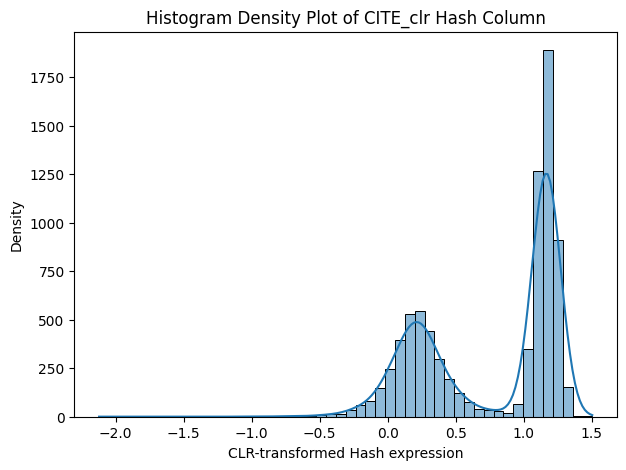

In [413]:
# Identify the index of the "Hash" column
hash_col_index = np.where(adata.uns["CITE_features"] == "Hash")[0][0]

# Extract the Hash column
hash_values = adata.obsm["CITE_clr"][:, hash_col_index]

# Plot density histogram
plt.figure(figsize=(7, 5))
sns.histplot(hash_values, kde=True, bins=50)

plt.xlabel("CLR-transformed Hash expression")
plt.ylabel("Density")
plt.title("Histogram Density Plot of CITE_clr Hash Column")
plt.show()

In [414]:
# Extract the Hash column from CITE_clr
hash_counts = adata.obsm["CITE_clr"][:, hash_col_index]

# Store the extracted counts in adata.obs
adata.obs["HashCounts"] = hash_counts

In [415]:
# Create 'manual_hash_dmux' based on HashCounts threshold
adata.obs["manual_hash_dmux"] = np.where(adata.obs["HashCounts"] > 0.8, "CITE_hash", "Negative")
adata.obs["manual_hash_dmux"].value_counts()


manual_hash_dmux
CITE_hash    4680
Negative     3311
Name: count, dtype: int64

In [416]:
import scipy.sparse as sp

# Identify index of "Unmapped"
unmapped_idx = np.where(adata.uns["Dextramer_features"] == "unmapped")[0][0]

# Remove "Unmapped" from feature list
adata.uns["Dextramer_features"] = np.delete(adata.uns["Dextramer_features"], unmapped_idx)

# Remove "Unmapped" from the Dextramer matrix
adata.obsm["Dextramer"] = sp.csr_matrix(np.delete(adata.obsm["Dextramer"].toarray(), unmapped_idx, axis=1))


In [417]:
# Sum total dextramer counts per cell and store in .obs
adata.obs["Dextramer_total_counts"] = adata.obsm["Dextramer"].sum(axis=1)

# Verify the new column
print(adata.obs["Dextramer_total_counts"].head())


AAACCTGAGAGACTAT-1    10
AAACCTGAGCCAGTAG-1    22
AAACCTGAGGAGTTGC-1    18
AAACCTGAGTACGACG-1    34
AAACCTGCACAGTCGC-1    13
Name: Dextramer_total_counts, dtype: int64


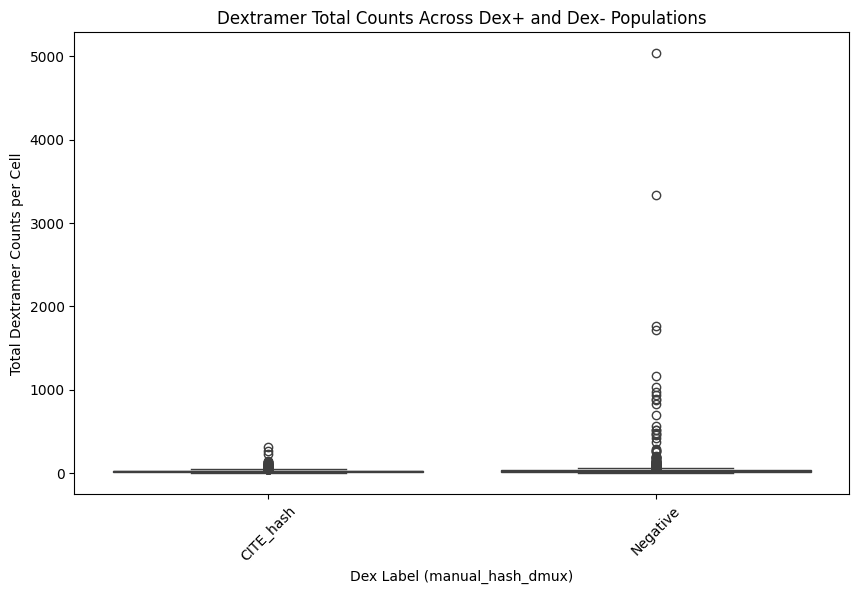

In [418]:
# Create a boxplot of Dextramer total counts grouped by manual_hash_dmux categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=adata.obs, x="manual_hash_dmux", y="Dextramer_total_counts")

# Customize plot labels and title
plt.xlabel("Dex Label (manual_hash_dmux)")
plt.ylabel("Total Dextramer Counts per Cell")
plt.title("Dextramer Total Counts Across Dex+ and Dex- Populations")

# Rotate x-axis labels if necessary for readability
plt.xticks(rotation=45)

plt.show()


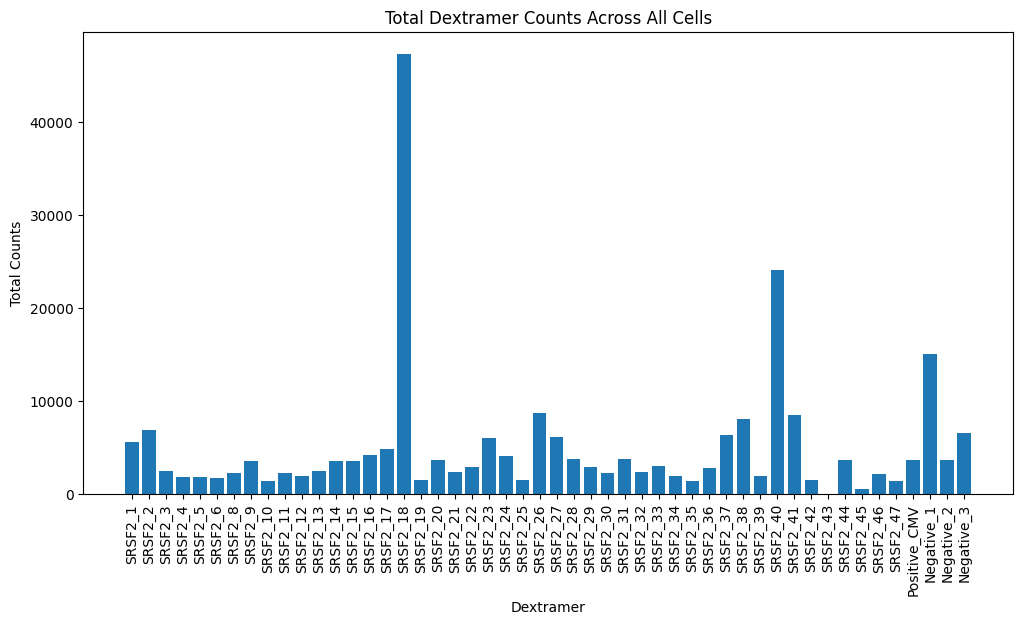

In [419]:
# Sum counts per dextramer across all cells
dextramer_counts = np.array(adata.obsm["Dextramer"].sum(axis=0)).flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(adata.uns["Dextramer_features"], dextramer_counts)
plt.xticks(rotation=90)
plt.xlabel("Dextramer")
plt.ylabel("Total Counts")
plt.title("Total Dextramer Counts Across All Cells")
plt.show()

Start building the feature set

In [420]:
# Extract dextramer matrix and convert to dense format
#dex_matrix = adata.obsm["Dextramer"].toarray()  # Convert sparse matrix to dense

# Compute mean and standard deviation for each dextramer feature
#dex_mean = np.mean(dex_matrix, axis=0)  # Mean per dextramer
#dex_std = np.std(dex_matrix, axis=0)    # Std per dextramer

# Apply Z-score normalization per dextramer
#dex_zscore = (dex_matrix - dex_mean) / dex_std

# Store the normalized dextramer signals back in adata
#adata.obsm["Dextramer_zscore"] = dex_zscore

# Verify normalization by checking mean and std
#zscore_means = np.mean(dex_zscore, axis=0)  # Should be close to 0
#zscore_stds = np.std(dex_zscore, axis=0)    # Should be close to 1

# Print sanity check results
print("Mean of Z-scored dextramers (should be ~0):", zscore_means[:5])
print("Std of Z-scored dextramers (should be ~1):", zscore_stds[:5])

Mean of Z-scored dextramers (should be ~0): [-1.54932450e-16 -1.37823574e-16 -7.64832656e-17  6.80916411e-17
  2.53388156e-16]
Std of Z-scored dextramers (should be ~1): [1. 1. 1. 1. 1.]


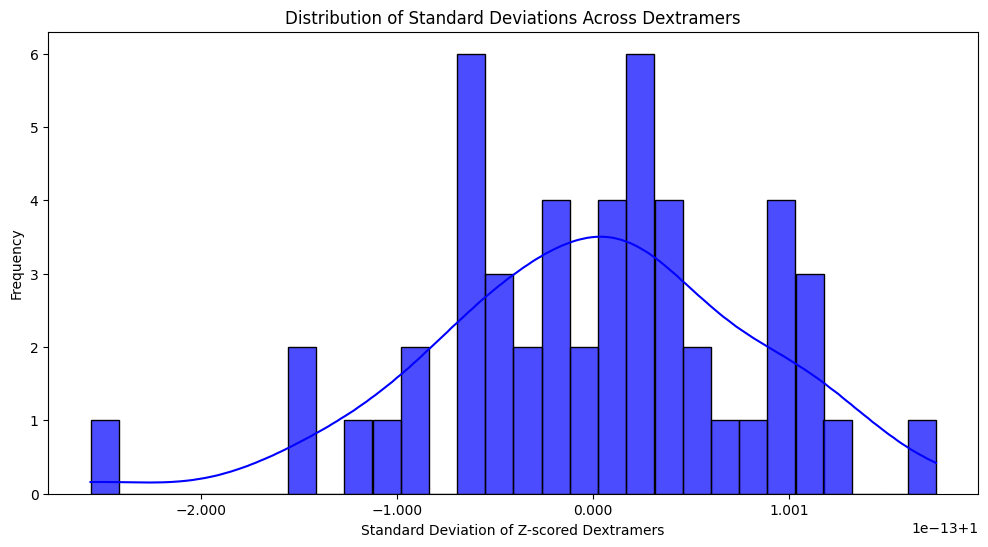

Top 10 dextramers with highest standard deviation:
   Dextramer  Standard_Deviation
19  SRSF2_21                 1.0
31  SRSF2_33                 1.0
44  SRSF2_46                 1.0
28  SRSF2_30                 1.0
10  SRSF2_12                 1.0
36  SRSF2_38                 1.0
21  SRSF2_23                 1.0
13  SRSF2_15                 1.0
40  SRSF2_42                 1.0
29  SRSF2_31                 1.0


In [364]:

# Compute standard deviation for each dextramer after Z-score normalization
#dex_std_values = np.std(adata.obsm["Dextramer_zscore"], axis=0)

# Convert to DataFrame for easier plotting
#dex_std_df = pd.DataFrame({"Dextramer": adata.uns["Dextramer_features"], "Standard_Deviation": dex_std_values})

# Plot standard deviation distribution
#plt.figure(figsize=(12, 6))
#sns.histplot(dex_std_df["Standard_Deviation"], bins=30, kde=True, color="blue", alpha=0.7)

#plt.xlabel("Standard Deviation of Z-scored Dextramers")
#plt.ylabel("Frequency")
#plt.title("Distribution of Standard Deviations Across Dextramers")
#plt.show()

# Print top dextramers with highest standard deviation
#dex_std_df_sorted = dex_std_df.sort_values(by="Standard_Deviation", ascending=False)
#print("Top 10 dextramers with highest standard deviation:")
#print(dex_std_df_sorted.head(10))

Find the fold change for each cell of the dextramer signal compared to the mean in the Dex-

In [424]:
# Extract dextramer matrix as dense array
dex_matrix = adata.obsm["Dextramer"].toarray()

# Extract Dex+ and Dex- labels
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex- cells (assumed to be background)
dex_neg_cells = dex_labels == "CITE_hash"  

# Compute the mean background signal for each dextramer using only Dex- cells
dex_background = dex_matrix[dex_neg_cells].mean(axis=0)  # Mean per dextramer in Dex- cells

# Normalize dextramer signals by their background (Fold-Change Enrichment)
dex_fold_change = dex_matrix / dex_background

# Apply log transformation to reduce extreme values (optional but recommended)
dex_log_fc = np.log1p(dex_fold_change)  # log(1 + x) transformation

# Store the background-normalized dextramer signals back in adata
adata.obsm["Dextramer_norm"] = dex_log_fc

# Print sanity check
print("Shape of normalized dextramer matrix:", adata.obsm["Dextramer_norm"].shape)
print("First few values of a random dextramer after normalization:\n", dex_log_fc[:, 0][:5])

Shape of normalized dextramer matrix: (7991, 50)
First few values of a random dextramer after normalization:
 [0. 0. 0. 0. 0.]


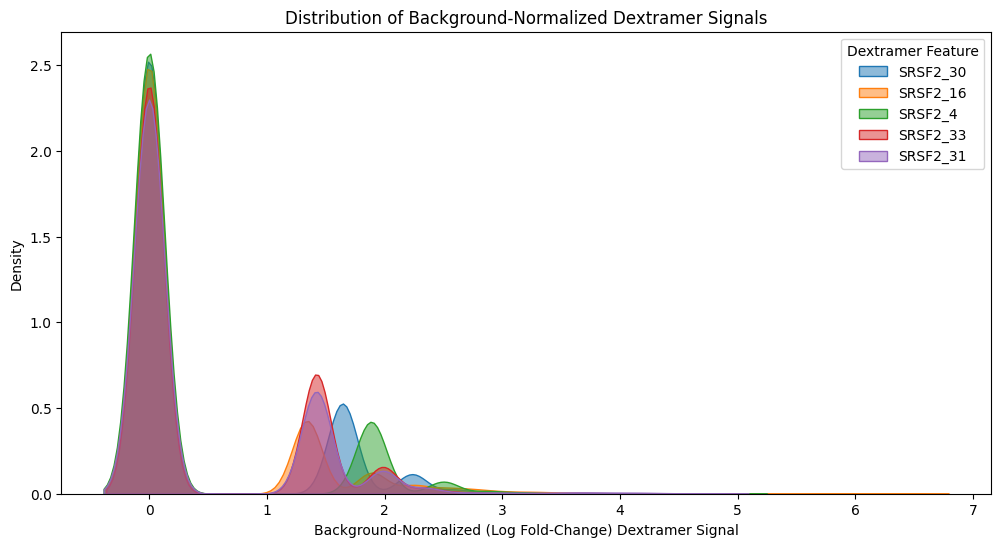

In [425]:
# Select a few dextramers to visualize (randomly choosing 5 for now)
num_features = adata.obsm["Dextramer_norm"].shape[1]
selected_dextramers = np.random.choice(num_features, size=5, replace=False)

# Convert the selected dextramers into a DataFrame for easier plotting
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"][:, selected_dextramers],
                           columns=[adata.uns["Dextramer_features"][i] for i in selected_dextramers])

# Plot the density distribution of the selected dextramer signals
plt.figure(figsize=(12, 6))
for col in dex_norm_df.columns:
    sns.kdeplot(dex_norm_df[col], label=col, fill=True, alpha=0.5)

plt.xlabel("Background-Normalized (Log Fold-Change) Dextramer Signal")
plt.ylabel("Density")
plt.title("Distribution of Background-Normalized Dextramer Signals")
plt.legend(title="Dextramer Feature")
plt.show()

Relative enrichment score per cell

In [429]:
# Identify Dex+ cells
dex_pos_cells = dex_labels != "CITE_hash" 

# Compute mean dextramer signal across Dex+ cells (per dextramer)
dex_mean_pos = dex_matrix[dex_pos_cells].mean(axis=0)  # Mean per dextramer in Dex+ cells

# Compute relative enrichment: deviation from Dex+ mean (per dextramer, per cell)
dex_enrichment = dex_matrix - dex_mean_pos  # Element-wise subtraction

# Store in adata
adata.obsm["Dextramer_enrichment"] = dex_enrichment

# Print sanity check
print("Shape of Dex+ enrichment matrix:", adata.obsm["Dextramer_enrichment"].shape)
print("First few values of a random dextramer after enrichment calculation:\n", dex_enrichment[:, 0][:5])

Shape of Dex+ enrichment matrix: (7991, 50)
First few values of a random dextramer after enrichment calculation:
 [-1.34340079 -1.34340079 -1.34340079 -1.34340079 -1.34340079]


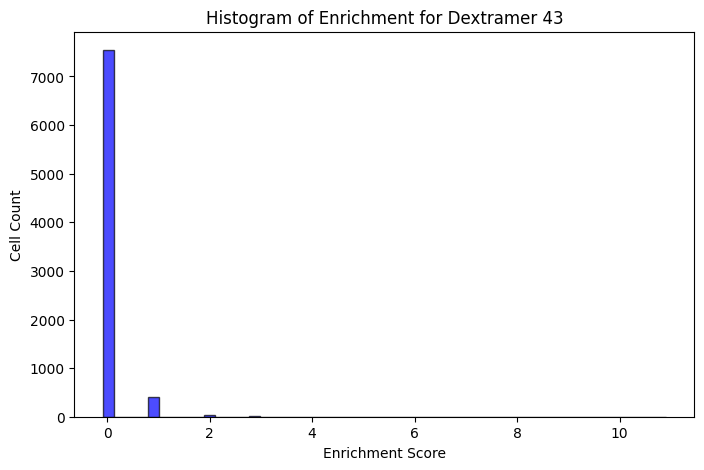

In [434]:
# Select a random dextramer (or a specific one)
dex_idx = 43  # Change this to visualize a different dextramer
dex_values = adata.obsm["Dextramer_enrichment"][:, dex_idx]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(dex_values, bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Enrichment Score")
plt.ylabel("Cell Count")
plt.title(f"Histogram of Enrichment for Dextramer {dex_idx}")
plt.show()

Identify enriched clonotypes within Dex+ cells

In [435]:
# Extract TCR clonotype IDs and Dex+/- labels
clonotypes = adata.obs["raw_clonotype_id"]
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex+ and Dex- cells based on corrected labels
dex_pos_mask = dex_labels == "Negative"  # Dex+ group
dex_neg_mask = dex_labels == "CITE_hash"  # Dex- group

# Compute total number of cells in each group
total_dex_pos = np.sum(dex_pos_mask)
total_dex_neg = np.sum(dex_neg_mask)

# Count occurrences of each clonotype in Dex+ and Dex- cells
clonotype_counts = pd.DataFrame({
    "Dex+ Count": clonotypes[dex_pos_mask].value_counts(),
    "Dex- Count": clonotypes[dex_neg_mask].value_counts()
}).fillna(0)


# Compute frequency (proportion) in each group
clonotype_counts["Dex+ Frequency"] = clonotype_counts["Dex+ Count"] / total_dex_pos
clonotype_counts["Dex- Frequency"] = clonotype_counts["Dex- Count"] / total_dex_neg

# Compute fold-change enrichment (log-scaled for better interpretability)
clonotype_counts["Enrichment Ratio"] = clonotype_counts["Dex+ Frequency"] / (clonotype_counts["Dex- Frequency"] + 1e-6)
clonotype_counts["Log Enrichment"] = np.log2(clonotype_counts["Enrichment Ratio"] + 1e-6)


# Store results in adata for later use
adata.uns["clonotype_enrichment"] = clonotype_counts

In [439]:
# Print top TCR clonotypes with highest enrichment
print("Top 10 TCR clonotypes enriched in Dex+ cells:")
print(clonotype_counts.sort_values(by="Dex+ Frequency", ascending=False).head(10))


Top 10 TCR clonotypes enriched in Dex+ cells:
                  Dex+ Count  Dex- Count  Dex+ Frequency  Dex- Frequency  \
raw_clonotype_id                                                           
clonotype1             137.0       369.0        0.041377        0.078846   
clonotype5             100.0       106.0        0.030202        0.022650   
clonotype2             100.0       198.0        0.030202        0.042308   
clonotype6              98.0        88.0        0.029598        0.018803   
clonotype3              77.0       182.0        0.023256        0.038889   
clonotype7              63.0        95.0        0.019027        0.020299   
clonotype16             56.0         1.0        0.016913        0.000214   
clonotype17             39.0        12.0        0.011779        0.002564   
clonotype8              32.0        79.0        0.009665        0.016880   
clonotype12             31.0        36.0        0.009363        0.007692   

                  Enrichment Ratio  Log E

Dextramer rankings and Dextramer competition score (ie. the margin between top dextramers per cell)

In [ ]:
# Use normalized dextramer data
dex_matrix_norm = adata.obsm["Dextramer_norm"]

# Compute ranks within each cell
dextramer_ranks = np.argsort(-dex_matrix_norm, axis=1)  # Descending order
dextramer_rank_values = np.argsort(dextramer_ranks, axis=1) + 1  # Convert to rank (1 = highest)

# Compute competition score
sorted_dex_values = np.sort(dex_matrix_norm, axis=1)[:, ::-1]  # Sort values descending
top_dextramer_signal = sorted_dex_values[:, 0]  # Strongest dextramer per cell
second_strongest_signal = sorted_dex_values[:, 1]  # Second strongest dextramer per cell

top_dextramer_margin = (top_dextramer_signal - second_strongest_signal) / (top_dextramer_signal + 1e-6)

# Store in adata for ML use later
adata.obsm["Dextramer_rank"] = dextramer_rank_values  # Rank matrix per cell/dextramer
adata.obs["Top_dextramer_margin"] = top_dextramer_margin  # One value per cell


In [445]:
# # Extract relevant data
# clonotypes = adata.obs["raw_clonotype_id"]
# # dex_norm_matrix = adata.obsm["Dextramer_norm"]
# dex_labels = adata.obs["manual_hash_dmux"]
# dextramer_features = adata.uns["Dextramer_features"]

# # Convert dextramer signals to DataFrame
# dex_df = pd.DataFrame(dex_norm_matrix, columns=dextramer_features, index=adata.obs.index)

# # Group by clonotype and compute key statistics
# clonotype_dex_features = dex_df.groupby(clonotypes).agg(["mean", "max", "var"])

# # Flatten multi-index column names
# clonotype_dex_features.columns = ["_".join(col).strip() for col in clonotype_dex_features.columns]

# # Compute mean dextramer signals per clonotype
# clonotype_mean_signal = dex_df.groupby(clonotypes).mean()

# # Replace `inf` values in the normalized matrix to prevent them from affecting selection
# clonotype_mean_signal.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Identify dominant dextramer per clonotype using a two-step approach:
# # 1. Pick the dextramer with the highest raw mean signal
# # 2. If there’s a tie or missing values, use the highest fold-change enrichment

# clonotype_dominant_dex = clonotype_mean_signal.idxmax(axis=1)

# # Compute fold-change enrichment for each dextramer in Dex+ vs. Dex-
# dex_mean_pos = dex_df[dex_labels == "Negative"].groupby(clonotypes).mean()
# dex_mean_neg = dex_df[dex_labels == "CITE_hash"].groupby(clonotypes).mean()

# clonotype_fold_change = np.log2((dex_mean_pos + 1e-6) / (dex_mean_neg + 1e-6))  # Log fold-change

# # Merge fold-change data with feature matrix
# clonotype_dex_features = clonotype_dex_features.merge(clonotype_fold_change, left_index=True, right_index=True, suffixes=("", "_logFC"))

# # Store the updated dominant dextramer selection
# clonotype_dex_features["Dominant_Dextramer"] = clonotype_dominant_dex

# # Store in adata for future use
# adata.uns["clonotype_dex_features"] = clonotype_dex_features

# # Print summary
# print("Top Clonotypes with Dominant Dextramer:")
# print(clonotype_dex_features[["Dominant_Dextramer"]].head(10))

# # Check updated dominant dextramer for clonotype16
# print("Dominant Dextramer for clonotype16:", clonotype_dex_features.loc["clonotype16", "Dominant_Dextramer"])


In [446]:
# # Separate Dex+ and Dex- populations
# dex_pos_mask = adata.obs["manual_hash_dmux"] == "Negative"  # Dex+ cells
# dex_neg_mask = adata.obs["manual_hash_dmux"] == "CITE_hash"  # Dex- cells

# # Compute mean dextramer expression for Dex+ and Dex-
# dex_mean_pos = X_dextramers.loc[dex_pos_mask, dex_numeric_cols].mean()
# dex_mean_neg = X_dextramers.loc[dex_neg_mask, dex_numeric_cols].mean()

# # Compute Log Fold-Change (LFC) Score
# dex_specificity_score = np.log2((dex_mean_pos + 1e-6) / (dex_mean_neg + 1e-6))

# # Add specificity score to feature matrix
# for dex in dex_numeric_cols:
#     X_dextramers[dex + "_LFC"] = dex_specificity_score[dex]

# # Print example specificity scores
# print("🔍 Example Dextramer Specificity Scores (LFC):")
# print(dex_specificity_score.sort_values(ascending=False))

In [447]:
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
# import pandas as pd

# ### **1️⃣ Load Normalized Dextramer Data**
# # Convert sparse normalized dextramer matrix to dense DataFrame
# X_dextramers = pd.DataFrame(
#     adata.obsm["Dextramer_norm"],  # Use normalized dextramer signals
#     columns=adata.uns["Dextramer_features"],
#     index=adata.obs.index
# )

# # Keep all other metadata features (Dex+ status, Clonotype info)
# X_dextramers["Dex_Status"] = (adata.obs["manual_hash_dmux"] == "Negative").astype(int)
# X_dextramers["Clonotype"] = adata.obs["raw_clonotype_id"]

# ### **2️⃣ Compute Clonotype Expansion**
# clonotype_counts = adata.obs["raw_clonotype_id"].value_counts()
# X_dextramers["Clonotype_Expansion"] = X_dextramers["Clonotype"].map(clonotype_counts)
# X_dextramers["Expanded_Clonotype"] = (X_dextramers["Clonotype_Expansion"] > 50).astype(int)

# ### **3️⃣ Compute Dextramer Specificity Score (Log Fold-Change)**
# # Separate Dex+ and Dex- populations
# dex_pos_mask = adata.obs["manual_hash_dmux"] == "Negative"  # Dex+ cells
# dex_neg_mask = adata.obs["manual_hash_dmux"] == "CITE_hash"  # Dex- cells

# # Compute mean dextramer expression for Dex+ and Dex-
# dex_mean_pos = X_dextramers.loc[dex_pos_mask, X_dextramers.columns[:-3]].mean()
# dex_mean_neg = X_dextramers.loc[dex_neg_mask, X_dextramers.columns[:-3]].mean()

# # Compute Log Fold-Change (LFC) Score
# dex_specificity_score = np.log2((dex_mean_pos + 1e-6) / (dex_mean_neg + 1e-6))

# # Add LFC scores as new features
# for dex in dex_specificity_score.index:
#     X_dextramers[dex + "_LFC"] = dex_specificity_score[dex]

# # Print example specificity scores
# print("🔍 Example Dextramer Specificity Scores (LFC):")
# print(dex_specificity_score.sort_values(ascending=False).head(10))

# ### **4️⃣ Remove the "Unmapped" Dextramer**
# if "unmapped" in X_dextramers.columns:
#     X_dextramers.drop(columns=["unmapped"], inplace=True)

# ### **5️⃣ Define Target (`y` = Most Strongly Expressed Dextramer)**
# dex_numeric_cols = [
#     col for col in X_dextramers.columns
#     if col in adata.uns["Dextramer_features"] and "AboveMean" not in col and "_LFC" not in col
# ]

# # Find the dextramer with the strongest signal per cell
# y = X_dextramers[dex_numeric_cols].idxmax(axis=1)

# print("📊 Target Distribution After Removing 'Unmapped' Dextramer:")
# print(y.value_counts())

# # **6️⃣ Handle Rare Dextramers Before Splitting**
# dex_counts = y.value_counts()
# rare_dextramers = dex_counts[dex_counts < 2].index.tolist()
# valid_samples = y.isin(rare_dextramers) == False
# X_dextramers = X_dextramers.loc[valid_samples]
# y = y.loc[valid_samples]

# # Ensure indices match before encoding
# common_indices = X_dextramers.index.intersection(y.index)
# X_dextramers = X_dextramers.loc[common_indices]
# y = y.loc[common_indices]

# # Encode target labels
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# print(f"✅ X_dextramers shape: {X_dextramers.shape}")
# print(f"✅ y_encoded shape: {y_encoded.shape}")


In [448]:
adata

AnnData object with n_obs × n_vars = 7991 × 20412
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'raw_clonotype_id', 'HashCounts', 'manual_hash_dmux', 'Dextramer_total_counts', 'Top_dextramer_margin'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'CITE_features', 'Dextramer_features', 'log1p', 'hvg', 'clonotype_enrichment'
    obsm: 'CITE', 'Dextramer', 'CITE_clr', 'Dextramer_norm', 'Dextramer_enrichment', 'Dextramer_rank'
    layers: 'counts'

In [372]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import numpy as np

# ### **6️⃣ Encode Clonotype Before Splitting**
# # Combine all Clonotype values before encoding (to prevent unseen labels)
# all_clonotypes = pd.concat([X_dextramers["Clonotype"]])

# # Fit encoder on full Clonotype list
# clonotype_encoder = LabelEncoder()
# clonotype_encoder.fit(all_clonotypes)

# # Encode Clonotype in train & test sets
# X_dextramers["Clonotype_Encoded"] = clonotype_encoder.transform(X_dextramers["Clonotype"])

# # Drop original Clonotype column
# X_dextramers = X_dextramers.drop(columns=["Clonotype"])

# print("✅ Clonotype Encoding Completed")

✅ Clonotype Encoding Completed


In [373]:
# # Ensure soft labels match each cell’s strongest dextramer signal
# y_prob = X_dextramers[dex_numeric_cols].idxmax(axis=1).map(dex_specificity_score)

# # Normalize between 0 and 1
# y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

# # Clip to ensure no values go beyond [0,1]
# y_prob = np.clip(y_prob, 0, 1)

# # Fill NaNs (if any) with 0
# y = y_prob.fillna(0)

# print("🔍 Example Soft Labels (Dex+ vs. Dex- Specificity Scores):")
# print(y.head(10))


🔍 Example Soft Labels (Dex+ vs. Dex- Specificity Scores):
AAACCTGAGAGACTAT-1    0.178996
AAACCTGAGCCAGTAG-1    0.291622
AAACCTGAGGAGTTGC-1    0.300828
AAACCTGAGTACGACG-1    0.212602
AAACCTGCACAGTCGC-1    0.281525
AAACCTGCACGGTAAG-1    0.281525
AAACCTGCAGTCGATT-1    0.169288
AAACCTGGTATAGTAG-1    0.199301
AAACCTGGTCTTCAAG-1    0.271035
AAACCTGGTGAGCGAT-1    0.354658
dtype: float64


In [374]:
# ### **8️⃣ Split the Data Into Training and Test Sets**
# X_train, X_test, y_train, y_test = train_test_split(
#     X_dextramers, y, test_size=0.2, random_state=42, stratify=None  # No stratification for soft labels
# )

# print(f"📊 Training Samples: {X_train.shape[0]}, Test Samples: {X_test.shape[0]}")

# # Check for missing values before training
# print("🔍 Checking for NaNs in X_train:", X_train.isna().sum().sum())
# print("🔍 Checking for NaNs in X_test:", X_test.isna().sum().sum())

# # Fix: Fill missing values with 0 (or use another imputation method if needed)
# X_train.fillna(0, inplace=True)
# X_test.fillna(0, inplace=True)

# # Replace inf and -inf values with 0
# X_train.replace([np.inf, -np.inf], 0, inplace=True)
# X_test.replace([np.inf, -np.inf], 0, inplace=True)

# # Confirm fix
# print("🔍 Checking for remaining inf values in X_train:", np.isinf(X_train).sum().sum())
# print("🔍 Checking for remaining inf values in X_test:", np.isinf(X_test).sum().sum())

# print("✅ Train-Test Split and Data Cleaning Completed")



📊 Training Samples: 6392, Test Samples: 1599
🔍 Checking for NaNs in X_train: 2249
🔍 Checking for NaNs in X_test: 559
🔍 Checking for remaining inf values in X_train: 0
🔍 Checking for remaining inf values in X_test: 0
✅ Train-Test Split and Data Cleaning Completed


In [375]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# ### **9️⃣ Train Random Forest Model (Regression)**
# rf_model = RandomForestRegressor(
#     n_estimators=200,  # Number of trees
#     random_state=42,
#     n_jobs=-1  # Use all CPU cores
# )

# rf_model.fit(X_train, y_train)

# # Predict on the test set
# y_pred = rf_model.predict(X_test)

# # Evaluate model performance
# mse = mean_squared_error(y_test, y_pred)
# print(f"📊 Model Performance: Mean Squared Error = {mse:.4f}")

# print("✅ Model Training and Evaluation Completed")


📊 Model Performance: Mean Squared Error = 0.0041
✅ Model Training and Evaluation Completed


In [376]:
# # Create a DataFrame to store actual vs. predicted binding probabilities
# results_df = pd.DataFrame({
#     "TCR_Clonotype": X_test.index.map(adata.obs["raw_clonotype_id"]),
#     "Predicted_Binding_Probability": y_pred,
#     "Most_Likely_Dextramer": X_test[dex_numeric_cols].idxmax(axis=1)  # Find the strongest predicted dextramer per cell
# })

# # Group by dextramer to find the clonotype with the highest mean predicted binding score
# top_dextramer_bindings = results_df.groupby("Most_Likely_Dextramer").apply(
#     lambda x: x.loc[x["Predicted_Binding_Probability"].idxmax()]
# )

# # Sort by highest predicted probability
# top_dextramer_bindings_sorted = top_dextramer_bindings.sort_values(by="Predicted_Binding_Probability", ascending=False)

# # Display top 20 dextramers and their most likely binding clonotype
# print("🔍 Top Predicted Dextramer-TCR Bindings:")
# print(top_dextramer_bindings_sorted.head(20))



🔍 Top Predicted Dextramer-TCR Bindings:
                      TCR_Clonotype  Predicted_Binding_Probability  \
Most_Likely_Dextramer                                                
SRSF2_43                 clonotype2                       1.000000   
SRSF2_47                        NaN                       0.547612   
SRSF2_31                        NaN                       0.534786   
SRSF2_3                         NaN                       0.518349   
SRSF2_21                        NaN                       0.464452   
SRSF2_35                 clonotype1                       0.459353   
SRSF2_8                 clonotype33                       0.455032   
SRSF2_30                clonotype47                       0.450884   
SRSF2_11                        NaN                       0.447202   
SRSF2_42               clonotype760                       0.437065   
SRSF2_16               clonotype695                       0.430037   
SRSF2_32               clonotype985               

<Figure size 1200x600 with 0 Axes>

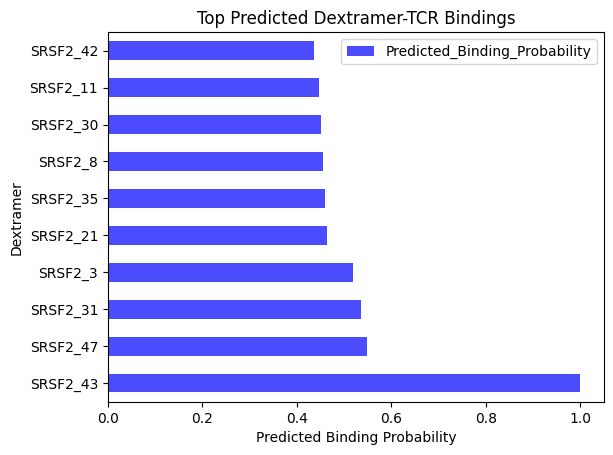

In [377]:
# # Plot top 10 dextramers and their strongest binding clonotype
# plt.figure(figsize=(12, 6))
# top_dextramer_bindings_sorted.head(10).plot(
#     kind="barh", x="Most_Likely_Dextramer", y="Predicted_Binding_Probability", color="blue", alpha=0.7
# )
# plt.xlabel("Predicted Binding Probability")
# plt.ylabel("Dextramer")
# plt.title("Top Predicted Dextramer-TCR Bindings")
# plt.show()

In [378]:
# # Get counts of clonotypes in Dex+ (Negative) and Dex- (CITE_hash)
# clonotype_counts = adata.obs.groupby(["raw_clonotype_id", "manual_hash_dmux"]).size().unstack(fill_value=0)

# # Ensure Dex+ (Negative) and Dex- (CITE_hash) exist in the dataframe
# clonotype_counts = clonotype_counts.rename(columns={"Negative": "Dex+", "CITE_hash": "Dex-"})

# # Compute the proportion of each clonotype in Dex+ (Negative)
# clonotype_counts["Dex+_Proportion"] = clonotype_counts["Dex+"] / clonotype_counts.sum(axis=1)

# # Set a threshold for Dex+ dominance (e.g., at least 60% Dex+ to be considered a binder)
# dex_positive_threshold = 0.8
# valid_clonotypes = clonotype_counts[clonotype_counts["Dex+_Proportion"] > dex_positive_threshold].index

# # Filter X_test and results_df to only include clonotypes passing the Dex+ threshold
# X_test_filtered = X_test[X_test.index.map(adata.obs["raw_clonotype_id"]).isin(valid_clonotypes)]
# results_df_filtered = results_df[results_df["TCR_Clonotype"].isin(valid_clonotypes)]

# # Recalculate top predicted dextramer bindings
# top_dextramer_bindings_filtered = results_df_filtered.groupby("Most_Likely_Dextramer").apply(
#     lambda x: x.loc[x["Predicted_Binding_Probability"].idxmax()]
# )

# # Sort by probability
# top_dextramer_bindings_filtered = top_dextramer_bindings_filtered.sort_values(by="Predicted_Binding_Probability", ascending=False)

# # Display updated results
# print("🔍 Top Predicted Dextramer-TCR Bindings (Filtered for Dex+ Enrichment):")
# print(top_dextramer_bindings_filtered.head(20))



🔍 Top Predicted Dextramer-TCR Bindings (Filtered for Dex+ Enrichment):
                       TCR_Clonotype  Predicted_Binding_Probability  \
Most_Likely_Dextramer                                                 
SRSF2_43                 clonotype16                       0.996909   
SRSF2_47               clonotype1310                       0.547612   
SRSF2_31                 clonotype16                       0.440145   
SRSF2_16                clonotype555                       0.417186   
SRSF2_35               clonotype1460                       0.384840   
SRSF2_42               clonotype1445                       0.381751   
SRSF2_10                clonotype717                       0.352307   
SRSF2_4                 clonotype573                       0.348740   
SRSF2_11                clonotype584                       0.327048   
SRSF2_12               clonotype1213                       0.318232   
SRSF2_39               clonotype1334                       0.309664   
SRSF2_

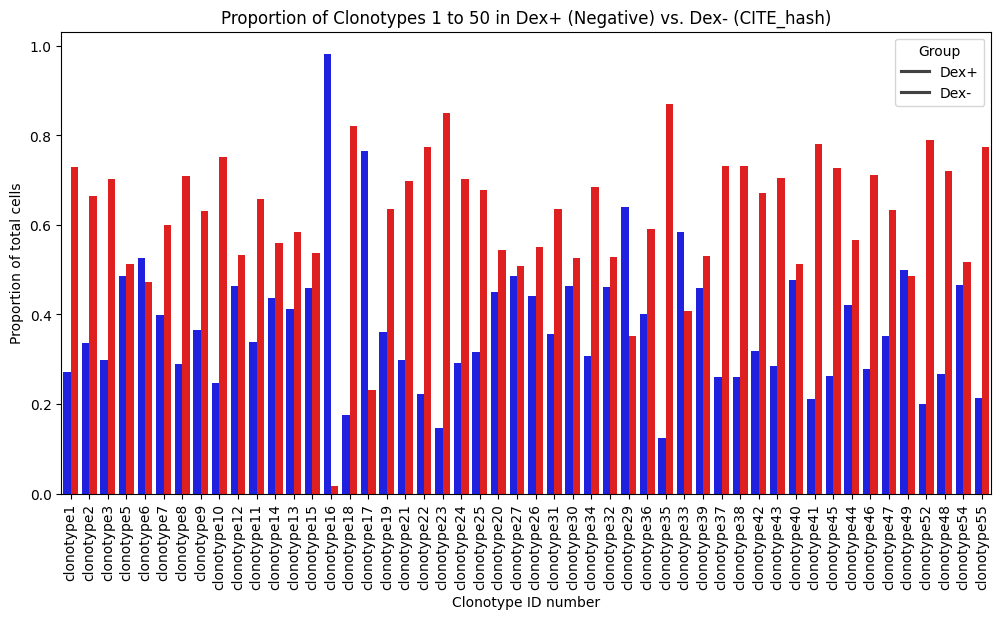

In [379]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Get counts of clonotypes in Dex+ (Negative) and Dex- (CITE_hash)
# clonotype_counts = adata.obs.groupby(["raw_clonotype_id", "manual_hash_dmux"]).size().unstack(fill_value=0)

# # Ensure Dex+ (Negative) and Dex- (CITE_hash) exist in the dataframe
# clonotype_counts = clonotype_counts.rename(columns={"Negative": "Dex+", "CITE_hash": "Dex-"})

# # Compute the proportion of each clonotype in Dex+ and Dex-
# clonotype_counts["Dex+_Proportion"] = clonotype_counts["Dex+"] / clonotype_counts.sum(axis=1)
# clonotype_counts["Dex-_Proportion"] = clonotype_counts["Dex-"] / clonotype_counts.sum(axis=1)

# # Sort clonotypes by total count and select top 50
# top_50_clonotypes = clonotype_counts.sum(axis=1).nlargest(50).index
# clonotype_counts_top50 = clonotype_counts.loc[top_50_clonotypes]

# # Melt dataframe for plotting
# clonotype_counts_top50_melted = clonotype_counts_top50.reset_index().melt(
#     id_vars="raw_clonotype_id", value_vars=["Dex+_Proportion", "Dex-_Proportion"],
#     var_name="group", value_name="Proportion"
# )

# # Plot frequencies of top 50 clonotypes in Dex+ vs Dex-
# plt.figure(figsize=(12, 6))
# sns.barplot(
#     data=clonotype_counts_top50_melted,
#     x="raw_clonotype_id", y="Proportion", hue="group",
#     palette={"Dex+_Proportion": "blue", "Dex-_Proportion": "red"}
# )
# plt.xticks(rotation=90)
# plt.xlabel("Clonotype ID number")
# plt.ylabel("Proportion of total cells")
# plt.title("Proportion of Clonotypes 1 to 50 in Dex+ (Negative) vs. Dex- (CITE_hash)")
# plt.legend(title="Group", labels=["Dex+", "Dex-"])
# plt.show()


New model (random forest)

In [541]:
# 1️⃣ Extract Cell-Level Features from `obs`
cell_features = adata.obs[["raw_clonotype_id", "Top_dextramer_margin"]].copy()

# Compute clonotype count
clonotype_counts = adata.obs["raw_clonotype_id"].value_counts().to_dict()
cell_features["clonotype_count"] = cell_features["raw_clonotype_id"].map(clonotype_counts)  # ✅ Added clonotype count

# 2️⃣ Extract Dextramer-Level Features from `obsm`
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"], index=adata.obs_names)
dex_rank_df = pd.DataFrame(adata.obsm["Dextramer_rank"], index=adata.obs_names)
dex_enrich_df = pd.DataFrame(adata.obsm["Dextramer_enrichment"], index=adata.obs_names)  # ✅ Added enrichment

# 3️⃣ Melt the data to create a (cell, dextramer) pair structure
dex_norm_melted = dex_norm_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_norm")
dex_rank_melted = dex_rank_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_rank")
dex_enrich_melted = dex_enrich_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_enrich")  # ✅ Included enrichment

# 4️⃣ Merge all dextramer-related features
dex_features = dex_norm_melted.merge(dex_rank_melted, on=["index", "dextramer"]).merge(dex_enrich_melted, on=["index", "dextramer"])  # ✅ Included enrichment

# 5️⃣ Merge with Cell-Level Features (now includes clonotype count)
X = pd.merge(dex_features, cell_features, left_on="index", right_index=True)

# Rename index for clarity
X.rename(columns={"index": "cell_id"}, inplace=True)


In [542]:
# Fill missing clonotype IDs with "Unknown"
X["raw_clonotype_id"] = X["raw_clonotype_id"].fillna("_no_clonotype_")

# Fill missing clonotype counts with 0
X["clonotype_count"] = X["clonotype_count"].fillna(0)

# Assuming dextramer feature names are stored in adata.var_names
dextramer_names = list(adata.uns["Dextramer_features"])  # This should contain actual dextramer names

# Create mapping from index to name
dex_index_to_name = {i: name for i, name in enumerate(dextramer_names)}

# Print a few mappings to verify
print("Example dextramer mapping:", list(dex_index_to_name.items())[:10])

Example dextramer mapping: [(0, 'SRSF2_1'), (1, 'SRSF2_2'), (2, 'SRSF2_3'), (3, 'SRSF2_4'), (4, 'SRSF2_5'), (5, 'SRSF2_6'), (6, 'SRSF2_8'), (7, 'SRSF2_9'), (8, 'SRSF2_10'), (9, 'SRSF2_11')]


In [543]:
# Apply mapping
X["dextramer"] = X["dextramer"].map(dex_index_to_name)

In [ ]:
# Convert stored enrichment DataFrame from adata.uns
clono_enrich_df = adata.uns["clonotype_enrichment"]

# Just keep the 'Log Enrichment' column (or whatever you want)
clono_enrich_df = clono_enrich_df[["Log Enrichment"]]

# Merge into your X DataFrame by raw_clonotype_id
X = X.merge(clono_enrich_df, left_on="raw_clonotype_id", right_index=True, how="left")


,cell_id,dextramer,dex_norm,dex_rank,dex_enrich,raw_clonotype_id,Top_dextramer_margin,clonotype_count,Log Enrichment
0,AAACCTGAGAGACTAT-1,SRSF2_1,0.000000,15,-1.343401,_no_clonotype_,0.029817,0.0,NaN
7991,AAACCTGAGAGACTAT-1,SRSF2_2,0.000000,29,-1.691634,_no_clonotype_,0.029817,0.0,NaN
15982,AAACCTGAGAGACTAT-1,SRSF2_3,0.000000,30,-0.380248,_no_clonotype_,0.029817,0.0,NaN
23973,AAACCTGAGAGACTAT-1,SRSF2_4,0.000000,31,-0.294171,_no_clonotype_,0.029817,0.0,NaN
31964,AAACCTGAGAGACTAT-1,SRSF2_5,0.000000,32,-0.288432,_no_clonotype_,0.029817,0.0,NaN
...,...,...,...,...,...,...,...,...,...
367585,TTTGTCATCATAAAGG-1,SRSF2_47,0.000000,20,-0.257928,clonotype3,0.231058,259.0,-0.741801
375576,TTTGTCATCATAAAGG-1,Positive_CMV,0.000000,15,-0.514648,clonotype3,0.231058,259.0,-0.741801
383567,TTTGTCATCATAAAGG-1,Negative_1,0.000000,11,-2.037451,clonotype3,0.231058,259.0,-0.741801
391558,TTTGTCATCATAAAGG-1,Negative_2,0.000000,27,-0.548475,clonotype3,0.231058,259.0,-0.741801


In [545]:

# Rename for consistency
X.rename(columns={"Log Enrichment": "clonotype_enrichment"}, inplace=True)

# Fill missing enrichment values with 0
X["clonotype_enrichment"] = X["clonotype_enrichment"].fillna(0)

# Sanity check
print(X[["raw_clonotype_id", "clonotype_enrichment"]].head())

      raw_clonotype_id  clonotype_enrichment
0       _no_clonotype_                   0.0
7991    _no_clonotype_                   0.0
15982   _no_clonotype_                   0.0
23973   _no_clonotype_                   0.0
31964   _no_clonotype_                   0.0


In [546]:
X

,cell_id,dextramer,dex_norm,dex_rank,dex_enrich,raw_clonotype_id,Top_dextramer_margin,clonotype_count,clonotype_enrichment
0,AAACCTGAGAGACTAT-1,SRSF2_1,0.000000,15,-1.343401,_no_clonotype_,0.029817,0.0,0.000000
7991,AAACCTGAGAGACTAT-1,SRSF2_2,0.000000,29,-1.691634,_no_clonotype_,0.029817,0.0,0.000000
15982,AAACCTGAGAGACTAT-1,SRSF2_3,0.000000,30,-0.380248,_no_clonotype_,0.029817,0.0,0.000000
23973,AAACCTGAGAGACTAT-1,SRSF2_4,0.000000,31,-0.294171,_no_clonotype_,0.029817,0.0,0.000000
31964,AAACCTGAGAGACTAT-1,SRSF2_5,0.000000,32,-0.288432,_no_clonotype_,0.029817,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
367585,TTTGTCATCATAAAGG-1,SRSF2_47,0.000000,20,-0.257928,clonotype3,0.231058,259.0,-0.741801
375576,TTTGTCATCATAAAGG-1,Positive_CMV,0.000000,15,-0.514648,clonotype3,0.231058,259.0,-0.741801
383567,TTTGTCATCATAAAGG-1,Negative_1,0.000000,11,-2.037451,clonotype3,0.231058,259.0,-0.741801
391558,TTTGTCATCATAAAGG-1,Negative_2,0.000000,27,-0.548475,clonotype3,0.231058,259.0,-0.741801


Code to incorporate partial ground truth

In [547]:
# Manually define the known true binder
known_true_pairs = [("clonotype16", "SRSF2_31")]

# Initialize y as all zeros (assume non-binder by default)
y = pd.Series(0, index=X.index)

# Set y = 1 for known true binders
y.loc[X[["raw_clonotype_id", "dextramer"]].apply(tuple, axis=1).isin(known_true_pairs)] = 1

print("Label distribution:\n", y.value_counts())


Label distribution:
 0    399493
1        57
Name: count, dtype: int64


In [548]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define features (excluding non-numeric columns)
feature_cols = [
    "dex_norm",
    "dex_rank",
    "dex_enrich",
    "Top_dextramer_margin",
    "clonotype_count",
    "clonotype_enrichment"  # <- new feature!
]

X_model = X[feature_cols]  # Feature matrix
y_model = y  # Target variable

# Split into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


Model Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     79899
           1       1.00      0.91      0.95        11

    accuracy                           1.00     79910
   macro avg       1.00      0.95      0.98     79910
weighted avg       1.00      1.00      1.00     79910



In [549]:
print(X.columns)  # Look for 'clonotype_enrichment'
print(X["clonotype_enrichment"].describe())  # Sanity check values


Index(['cell_id', 'dextramer', 'dex_norm', 'dex_rank', 'dex_enrich',
       'raw_clonotype_id', 'Top_dextramer_margin', 'clonotype_count',
       'clonotype_enrichment'],
      dtype='object')
count    399550.000000
mean         -1.079862
std           5.505596
min         -19.931569
25%          -0.741801
50%           0.000000
75%           0.000000
max          10.560445
Name: clonotype_enrichment, dtype: float64


Isolation forest model

In [550]:
from sklearn.ensemble import IsolationForest

# Define Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)  # 0.1% expected outliers

# Fit the model on scaled data
iso_forest.fit(X_scaled)

# Predict anomaly scores (-1 = outlier, 1 = inlier)
X["binding_anomaly_score"] = iso_forest.decision_function(X_scaled)  # Higher = more normal, lower = more anomalous
X["is_likely_binder"] = iso_forest.predict(X_scaled)  # -1 means likely binder, 1 means normal background

print("Isolation Forest model trained ✅")

Isolation Forest model trained ✅


In [551]:
# Group by (dextramer, clonotype)
X_grouped = X.groupby(["dextramer", "raw_clonotype_id"]).agg(
    mean_score=("binding_anomaly_score", "mean"),  # Average anomaly score
    min_score=("binding_anomaly_score", "min"),    # Best anomaly score
    count=("binding_anomaly_score", "count")       # How often this pair appears
).reset_index()

# Compute a final ranking score (higher weight for best anomaly score, adjusted by count)
X_grouped["final_score"] = X_grouped["min_score"] * 0.7 + X_grouped["mean_score"] * 0.3

# Rank by final score (lower = better binder)
X_ranked = X_grouped.sort_values(by="final_score")

# Display top predicted unique binding pairs
print("Top predicted unique neoantigen-TCR binding pairs:\n", X_ranked.head(50))


Top predicted unique neoantigen-TCR binding pairs:
           dextramer raw_clonotype_id  mean_score  min_score  count  \
16257       SRSF2_2     clonotype558   -0.052128  -0.052128      1   
29228      SRSF2_31      clonotype16    0.011904  -0.051390     57   
5303       SRSF2_10    clonotype1249   -0.027695  -0.027695      1   
29148      SRSF2_31    clonotype1467   -0.023375  -0.023375      1   
22918      SRSF2_26    clonotype1353   -0.023274  -0.023274      1   
39179      SRSF2_40       clonotype1    0.079725  -0.054834    506   
24707      SRSF2_27     clonotype950   -0.014346  -0.014346      1   
11342      SRSF2_16       clonotype1    0.123325  -0.068761    506   
21614      SRSF2_24     clonotype950   -0.009393  -0.009393      1   
13404      SRSF2_18       clonotype1    0.061151  -0.038849    506   
22683      SRSF2_26       clonotype1    0.102906  -0.055124    506   
17490      SRSF2_20     clonotype950   -0.006593  -0.006593      1   
13724      SRSF2_18    clonotype1519  

XGBoost

In [553]:
from xgboost import XGBRegressor

# Feature set
feature_cols = ["dex_rank", "dex_enrich", "Top_dextramer_margin", "clonotype_count", "clonotype_enrichment"]
X_model = X[feature_cols]

# Target = normalized dextramer signal (assumed indicative of binding strength)
y_model = X["dex_norm"]


In [554]:
# Initialize and train model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_model, y_model)

print("✅ XGBoost model trained on dex_norm as target")



✅ XGBoost model trained on dex_norm as target


In [555]:
# Predict binding likelihood for all (clonotype, dextramer) pairs
X["binding_score_xgb"] = xgb_model.predict(X_model)



In [556]:
# Aggregate: mean predicted score per (dextramer, clonotype)
X_grouped = X.groupby(["dextramer", "raw_clonotype_id"])["binding_score_xgb"].mean().reset_index()

# Rank: sort by predicted binding score (descending = more likely)
X_ranked = X_grouped.sort_values(by="binding_score_xgb", ascending=False)

# Show top predicted binders
print("🔝 Top predicted neoantigen–TCR binding pairs (by XGBoost on dex_norm):\n")
print(X_ranked.head(50))


🔝 Top predicted neoantigen–TCR binding pairs (by XGBoost on dex_norm):

        dextramer raw_clonotype_id  binding_score_xgb
16257     SRSF2_2     clonotype558           5.231493
5303     SRSF2_10    clonotype1249           5.024483
43028    SRSF2_43     clonotype499           4.371405
6082     SRSF2_10     clonotype785           3.953408
44533    SRSF2_45    clonotype1311           3.787184
29148    SRSF2_31    clonotype1467           3.526020
22918    SRSF2_26    clonotype1353           3.434792
4327      SRSF2_1    clonotype1315           3.411839
11677    SRSF2_16    clonotype1543           3.376239
39391    SRSF2_40    clonotype1327           3.376239
14738    SRSF2_19    clonotype1499           3.354036
29228    SRSF2_31      clonotype16           3.309332
27692     SRSF2_3     clonotype730           3.295249
47319    SRSF2_47     clonotype781           3.295249
13366    SRSF2_17     clonotype950           3.253108
11304    SRSF2_15     clonotype950           3.253108
24707    S

In [557]:
# Step 1: Rank dextramer-clonotype pairs within each cell
X["in_cell_rank"] = X.groupby("cell_id")["binding_score_xgb"].rank(method="average", ascending=False)

# Step 2: Aggregate by (dextramer, clonotype)
pairwise_ranks = X.groupby(["dextramer", "raw_clonotype_id"]).agg(
    mean_rank=("in_cell_rank", "mean"),
    num_cells=("in_cell_rank", "count"),
    mean_score=("binding_score_xgb", "mean")  # optional: useful for sorting
).reset_index()

# Step 3: Sort by rank
pairwise_ranks = pairwise_ranks.sort_values(by="mean_rank", ascending=True)

# Optional filter: remove pairs seen in very few cells
pairwise_ranks = pairwise_ranks[pairwise_ranks["num_cells"] >= 5]

# Show top predicted TCR–dextramer pairings
print("Top predicted TCR–neoantigen pairs (by average model rank across cells):")
print(pairwise_ranks.head(20))


Top predicted TCR–neoantigen pairs (by average model rank across cells):
        dextramer raw_clonotype_id  mean_rank  num_cells  mean_score
29228    SRSF2_31      clonotype16   1.263158         57    3.309332
1337   Negative_2     clonotype150   4.200000          5    1.682190
35185    SRSF2_37     clonotype122   6.333333          6    0.983630
13584    SRSF2_18     clonotype129   7.300000          5    1.274179
39336    SRSF2_40     clonotype126   7.333333          6    1.452545
13675    SRSF2_18     clonotype146   7.400000          5    0.695596
1022   Negative_1      clonotype99   7.750000          8    0.967034
38574     SRSF2_4      clonotype17   7.833333         51    2.016126
40456    SRSF2_41     clonotype137   8.200000          5    1.186471
24055    SRSF2_27     clonotype155   8.200000          5    1.135232
40200    SRSF2_40      clonotype99   8.250000          8    0.911369
13731    SRSF2_18     clonotype153   8.400000          5    0.994922
32184    SRSF2_34     clonotyp

In [558]:
# Set conservative threshold: only keep predictions with strong scores and low rank
high_confidence = pairwise_ranks[
    (pairwise_ranks["mean_rank"] <= 3) &  # Consistently ranked high in cells
    (pairwise_ranks["mean_score"] >= 1.5) &  # High model-predicted score
    (~pairwise_ranks["dextramer"].str.contains("Negative"))  # Exclude known non-binders
]

print("High-confidence predicted binders:\n", high_confidence)


High-confidence predicted binders:
       dextramer raw_clonotype_id  mean_rank  num_cells  mean_score
29228  SRSF2_31      clonotype16   1.263158         57    3.309332


In [561]:
import joblib
joblib.dump(xgb_model, "xgb_binder_model.pkl")


['xgb_binder_model.pkl']

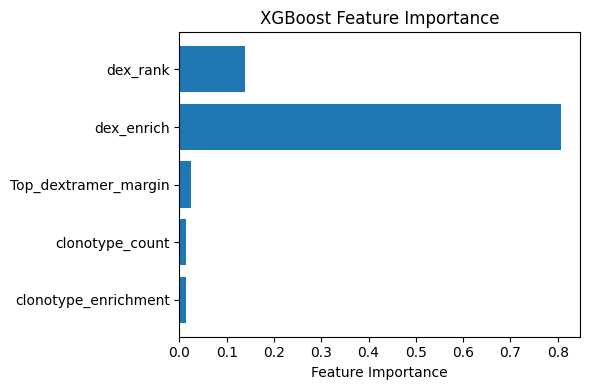

In [560]:
# Get importance scores
importance = xgb_model.feature_importances_
features = xgb_model.get_booster().feature_names

# Plot
plt.figure(figsize=(6, 4))
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()